# Fase 6: Integración de Clusters en los Modelos Supervisados

En esta fase se evalúa si los **clusters obtenidos en el aprendizaje no supervisado** (Fase 5) aportan valor a los modelos supervisados de:

- **Regresión** (predicción de una variable continua)
- **Clasificación** (predicción de una clase)

La idea es comparar el desempeño de los modelos:

1. **Sin clusters** (solo con las variables originales).
2. **Con clusters** como *feature adicional*.

De esta forma se puede responder si la segmentación obtenida en la Fase 5 ayuda a mejorar las predicciones o al menos aporta una mejor interpretación de los resultados.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, classification_report

plt.style.use("ggplot")
sns.set()

RANDOM_STATE = 42

## 1. Carga de datos

Se cargan las matrices de features y etiquetas para regresión y clasificación, junto con los resultados de clustering. 

> Nota: este notebook asume que se ejecuta desde la carpeta `notebooks`, por eso se usan rutas relativas `../data/...`.


In [2]:
# Features y labels base (sin clusters)
X_reg = pd.read_csv("../data/04_feature/X_reg.csv")
y_reg = pd.read_csv("../data/04_feature/y_reg.csv").squeeze()  # convertir a Series si es 1 columna

X_clf = pd.read_csv("../data/04_feature/X_clf.csv")
y_clf = pd.read_csv("../data/04_feature/y_clf.csv").squeeze()

print("Shapes originales:")
print("X_reg:", X_reg.shape, "y_reg:", y_reg.shape)
print("X_clf:", X_clf.shape, "y_clf:", y_clf.shape)

Shapes originales:
X_reg: (3818, 120) y_reg: (3818,)
X_clf: (3818, 121) y_clf: (3818,)


In [3]:
# Resultados de clustering (contienen labels de cluster)
clustering_results = pd.read_csv("../data/07_model_output/clustering_results.csv")
print("Shape clustering_results:", clustering_results.shape)
clustering_results.head()

Shape clustering_results: (3818, 123)


,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,weekly_price,monthly_price,security_deposit,cleaning_fee,...,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,kmeans_4_labels,dbscan_labels,gmm_4_labels
0,4.0,1.0,1.0,1.0,207.0,95.0,650.0,2200.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
1,4.0,1.0,1.0,1.0,43.0,96.0,1000.0,3000.0,100.0,40.0,...,False,False,False,False,False,False,False,0,-1,3
2,11.0,4.5,5.0,7.0,20.0,97.0,650.0,2200.0,1000.0,300.0,...,True,False,False,False,False,False,False,1,-1,3
3,3.0,1.0,0.0,2.0,0.0,96.0,650.0,2300.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
4,6.0,2.0,3.0,3.0,38.0,92.0,650.0,2200.0,700.0,125.0,...,True,False,False,False,False,False,False,1,-1,3


## 2. Integración de los clusters como feature

Los clusters calculados en la Fase 5 se incorporan como una nueva columna en las matrices de features:

- Se detecta automáticamente una columna cuyo nombre contenga `"kmeans"` y `"labels"`.
- Esa columna se usará como `cluster_feature`.

El orden de las filas de `clustering_results` es el mismo que el de `X_reg` / `X_clf` (porque el clustering se realizó sobre esas mismas features).


In [4]:
# Detectar columna de labels de K-Means
cluster_cols = [c for c in clustering_results.columns if "labels" in c]
print("Columnas de labels encontradas:", cluster_cols)

if not cluster_cols:
    raise ValueError("No se encontró ninguna columna de labels en clustering_results. Revisa el pipeline de clustering.")

# Preferimos la de K-Means si existe, si no usamos la primera
kmeans_cols = [c for c in cluster_cols if "kmeans" in c]
cluster_col = kmeans_cols[0] if kmeans_cols else cluster_cols[0]

print("Usando columna de cluster:", cluster_col)

Columnas de labels encontradas: ['kmeans_4_labels', 'dbscan_labels', 'gmm_4_labels']
Usando columna de cluster: kmeans_4_labels


In [5]:
# Crear copias con la feature de cluster
X_reg_with_cluster = X_reg.copy()
X_reg_with_cluster["cluster"] = clustering_results[cluster_col].values

X_clf_with_cluster = X_clf.copy()
X_clf_with_cluster["cluster"] = clustering_results[cluster_col].values

X_reg_with_cluster.head()

,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,weekly_price,monthly_price,security_deposit,cleaning_fee,...,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,cluster
0,4.0,1.0,1.0,1.0,207.0,95.0,650.0,2200.0,250.0,50.0,...,False,False,False,False,False,False,False,False,False,1
1,4.0,1.0,1.0,1.0,43.0,96.0,1000.0,3000.0,100.0,40.0,...,False,False,False,False,False,False,False,False,False,0
2,11.0,4.5,5.0,7.0,20.0,97.0,650.0,2200.0,1000.0,300.0,...,False,False,True,False,False,False,False,False,False,1
3,3.0,1.0,0.0,2.0,0.0,96.0,650.0,2300.0,250.0,50.0,...,False,False,False,False,False,False,False,False,False,1
4,6.0,2.0,3.0,3.0,38.0,92.0,650.0,2200.0,700.0,125.0,...,False,False,True,False,False,False,False,False,False,1


## 3. División en entrenamiento y prueba

Para comparar de forma justa los modelos con y sin clusters, se utiliza la **misma partición** de entrenamiento/test en ambos casos.

Se usa un `test_size` de 20% y `random_state` fijo.


In [6]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

Xr_train_c, Xr_test_c, yr_train_c, yr_test_c = train_test_split(
    X_reg_with_cluster, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)

Xc_train_c, Xc_test_c, yc_train_c, yc_test_c = train_test_split(
    X_clf_with_cluster, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)

print("Regresión sin cluster:", Xr_train.shape, Xr_test.shape)
print("Regresión con cluster:", Xr_train_c.shape, Xr_test_c.shape)
print("Clasificación sin cluster:", Xc_train.shape, Xc_test.shape)
print("Clasificación con cluster:", Xc_train_c.shape, Xc_test_c.shape)

Regresión sin cluster: (3054, 120) (764, 120)
Regresión con cluster: (3054, 121) (764, 121)
Clasificación sin cluster: (3054, 121) (764, 121)
Clasificación con cluster: (3054, 122) (764, 122)


## 4. Modelos de Regresión

Se entrena un modelo base de regresión (Random Forest Regressor) en dos escenarios:

1. **Modelo base**: solo con `X_reg` (sin clusters).
2. **Modelo extendido**: con `X_reg` + columna de `cluster`.

Se comparan métricas:

- **MSE** (Error cuadrático medio)
- **MAE** (Error absoluto medio)
- **R²** (coeficiente de determinación)


In [7]:
reg_base = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

reg_with_cluster = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

reg_base.fit(Xr_train, yr_train)
reg_with_cluster.fit(Xr_train_c, yr_train_c)

yr_pred_base = reg_base.predict(Xr_test)
yr_pred_cluster = reg_with_cluster.predict(Xr_test_c)

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

mse_b, mae_b, r2_b = regression_metrics(yr_test, yr_pred_base)
mse_c, mae_c, r2_c = regression_metrics(yr_test_c, yr_pred_cluster)

reg_results = pd.DataFrame(
    {
        "modelo": ["base_sin_cluster", "con_cluster"],
        "MSE": [mse_b, mse_c],
        "MAE": [mae_b, mae_c],
        "R2": [r2_b, r2_c],
    }
)
reg_results

,modelo,MSE,MAE,R2
0,base_sin_cluster,847.783354,12.215818,0.895546
1,con_cluster,832.137663,12.141440,0.897473


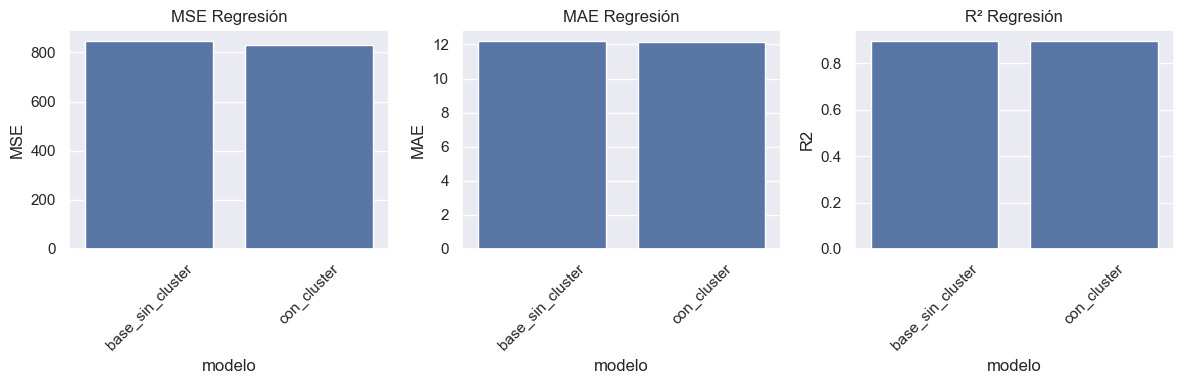

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.barplot(data=reg_results, x="modelo", y="MSE", ax=axes[0])
axes[0].set_title("MSE Regresión")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(data=reg_results, x="modelo", y="MAE", ax=axes[1])
axes[1].set_title("MAE Regresión")
axes[1].tick_params(axis="x", rotation=45)

sns.barplot(data=reg_results, x="modelo", y="R2", ax=axes[2])
axes[2].set_title("R² Regresión")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Comentario de resultados en Regresión

- Si el modelo **con cluster** tiene menor MSE/MAE y mayor R², se puede decir que los clusters **aportan información útil** para la predicción.
- Si el desempeño es similar, los clusters pueden seguir siendo útiles para **interpretar segmentos**, aunque no mejoren demasiado las métricas.
- Si el modelo con clusters empeora, puede indicar que el cluster está introduciendo ruido o que no está bien alineado con la variable a predecir.



## 5. Modelos de Clasificación

De forma análoga, se entrena un modelo de clasificación (Random Forest Classifier) en dos escenarios:

1. **Modelo base**: solo con `X_clf`.
2. **Modelo extendido**: con `X_clf` + `cluster`.

Se comparan métricas:

- **Accuracy**
- **F1-score macro**


In [9]:
clf_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

clf_with_cluster = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

clf_base.fit(Xc_train, yc_train)
clf_with_cluster.fit(Xc_train_c, yc_train_c)

yc_pred_base = clf_base.predict(Xc_test)
yc_pred_cluster = clf_with_cluster.predict(Xc_test_c)

acc_b = accuracy_score(yc_test, yc_pred_base)
acc_c = accuracy_score(yc_test_c, yc_pred_cluster)

f1_b = f1_score(yc_test, yc_pred_base, average="macro")
f1_c = f1_score(yc_test_c, yc_pred_cluster, average="macro")

clf_results = pd.DataFrame(
    {
        "modelo": ["base_sin_cluster", "con_cluster"],
        "accuracy": [acc_b, acc_c],
        "f1_macro": [f1_b, f1_c],
    }
)
clf_results

,modelo,accuracy,f1_macro
0,base_sin_cluster,0.853403,0.529174
1,con_cluster,0.852094,0.521630


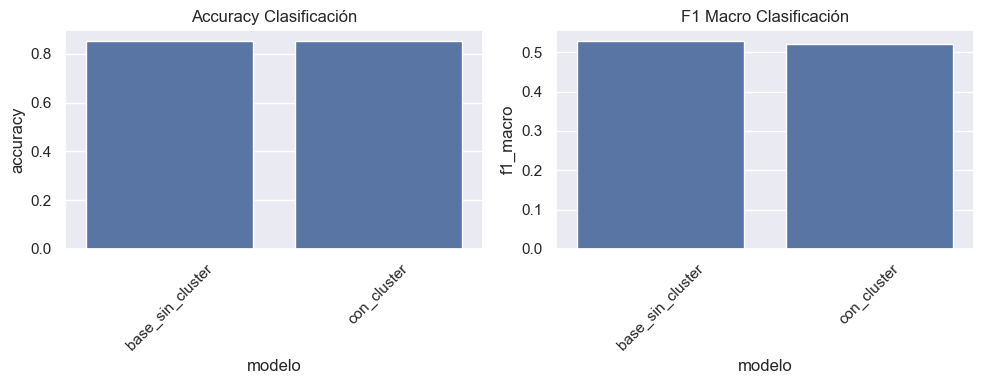

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=clf_results, x="modelo", y="accuracy", ax=axes[0])
axes[0].set_title("Accuracy Clasificación")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(data=clf_results, x="modelo", y="f1_macro", ax=axes[1])
axes[1].set_title("F1 Macro Clasificación")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [11]:
print("Reporte de clasificación - modelo base (sin cluster):")
print(classification_report(yc_test, yc_pred_base))

print("\nReporte de clasificación - modelo con cluster:")
print(classification_report(yc_test_c, yc_pred_cluster))

Reporte de clasificación - modelo base (sin cluster):
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       646
           1       0.75      0.08      0.14       118

    accuracy                           0.85       764
   macro avg       0.80      0.54      0.53       764
weighted avg       0.84      0.85      0.80       764


Reporte de clasificación - modelo con cluster:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       646
           1       0.73      0.07      0.12       118

    accuracy                           0.85       764
   macro avg       0.79      0.53      0.52       764
weighted avg       0.83      0.85      0.80       764



### Comentario de resultados en Clasificación

- Observar si el modelo con cluster **mejora** accuracy y F1-macro respecto al modelo base.
- Analizar si mejora el desempeño en clases minoritarias (revisando el `classification_report`).
- Explicar posibles razones de mejora o no mejora, relacionándolo con la naturaleza de los clusters.

*(Aquí redacta tu análisis según los resultados que obtengas.)*


## 6. Conclusiones Generales de la Fase 6

En esta sección se integran los hallazgos de los experimentos:

- ¿Los clusters ayudaron a **mejorar el desempeño** de los modelos de regresión y clasificación?
- Incluso si las métricas no mejoran mucho, ¿los clusters aportan una **interpretación más rica** de los resultados (por ejemplo, performance por segmento)?
- ¿Qué recomendarías a nivel de negocio basándote en estos resultados?



- Los clusters pueden usarse para definir **estrategias de precios diferenciadas** por segmento.
- Se pueden diseñar campañas o promociones específicas para ciertos clusters.
- Los modelos supervisados podrían entrenarse por separado dentro de cada cluster para personalizar aún más las predicciones.

Esta fase cierra la integración entre **aprendizaje no supervisado** y **supervisado**, mostrando cómo ambas perspectivas se complementan en un problema real.


In [12]:
import pandas as pd

df = pd.read_csv("../data/07_model_output/clustering_results.csv")
df.head(10)


,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,weekly_price,monthly_price,security_deposit,cleaning_fee,...,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,kmeans_4_labels,dbscan_labels,gmm_4_labels
0,4.0,1.0,1.0,1.0,207.0,95.0,650.0,2200.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
1,4.0,1.0,1.0,1.0,43.0,96.0,1000.0,3000.0,100.0,40.0,...,False,False,False,False,False,False,False,0,-1,3
2,11.0,4.5,5.0,7.0,20.0,97.0,650.0,2200.0,1000.0,300.0,...,True,False,False,False,False,False,False,1,-1,3
3,3.0,1.0,0.0,2.0,0.0,96.0,650.0,2300.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
4,6.0,2.0,3.0,3.0,38.0,92.0,650.0,2200.0,700.0,125.0,...,True,False,False,False,False,False,False,1,-1,3
5,2.0,1.0,1.0,1.0,17.0,95.0,800.0,2200.0,250.0,40.0,...,True,False,False,False,False,False,False,1,-1,3
6,2.0,1.0,1.0,1.0,58.0,99.0,575.0,2200.0,150.0,50.0,...,True,False,False,False,False,False,False,1,-1,3
7,2.0,1.0,1.0,1.0,173.0,97.0,360.0,2200.0,150.0,25.0,...,False,False,False,False,False,False,False,1,-1,1
8,2.0,1.0,1.0,1.0,8.0,97.0,500.0,1700.0,250.0,50.0,...,False,False,False,False,False,False,False,1,-1,3
9,4.0,1.0,1.0,1.0,32.0,97.0,1000.0,3000.0,100.0,40.0,...,False,False,False,False,False,False,False,0,-1,3
